# Computer Vision Coursework

In [1]:
### Importing necessary libraries
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import time

## Exploratory Data Analysis

### Basic Stats

In [2]:
### Loading matlab files in Python using Scipy
import scipy.io
mat = scipy.io.loadmat('Brain.mat')

In [3]:
T1, label = mat['T1'], mat['label']

In [4]:
### T1 is the array with the input MRI images, 10 samples each of size 362x434 pixels.
T1.shape

(362, 434, 10)

In [5]:
### range of pixel values in a sample of T1
sample = T1[:,:,0]
print(f"""Max pixel value: {round(sample.min(),0)}, 
Min pixel value: {round(sample.max(),0)},
Average pixel value: {round(sample.mean(),0)}""")

Max pixel value: 959.0, 
Min pixel value: 491434.0,
Average pixel value: 164930.0


- From the above cell, we can see that the obtained input image is not in standard color range `0-255`. Thus, we need to apply the standardisation technique `(x -> (x-xmin)/(xmax-xmin))` that will convert the pixel to the range `[0,1]`. Multiply the obtained pixel values with 255 and take the integer value to get the standard `0-255` representation of the image

In [6]:
sample_std = ((sample - sample.min()) * (1/(sample.max() - sample.min()) * 255)).astype('uint8')
print(f"""Standardized image:
Max pixel value: {round(sample_std.min(),0)}, 
Min pixel value: {round(sample_std.max(),0)},
Average pixel value: {round(sample_std.mean(),0)}""")

Standardized image:
Max pixel value: 0, 
Min pixel value: 255,
Average pixel value: 85.0


### Visualising images

In [7]:
### function to plot single image
def show_image(image,cmap = 'gray',fig_size = 10):
    plt.figure(figsize = (fig_size,fig_size))
    fig  = plt.imshow(image,cmap = cmap)
    plt.show()

### function to visualise label images
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    # convert hsv2bgr for visualsiation
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    # set background label to black
    labeled_img[label_hue==0] = 0
    return labeled_img

### function to plot multiple images as subplot
def plot_multi(images, cmap='gray', fig_size = 20):
    plt.figure(figsize=(fig_size, fig_size))
    length = len(images)
    sq_root = int(length**0.5)
    for i in range(length):
        plt.subplot(sq_root+1,sq_root+1,i+1)
        plt.imshow(images[i],cmap = cmap)
        plt.xlabel(f"index: {i+1}")


#### Plotting original image and Standardised image to check for data loss

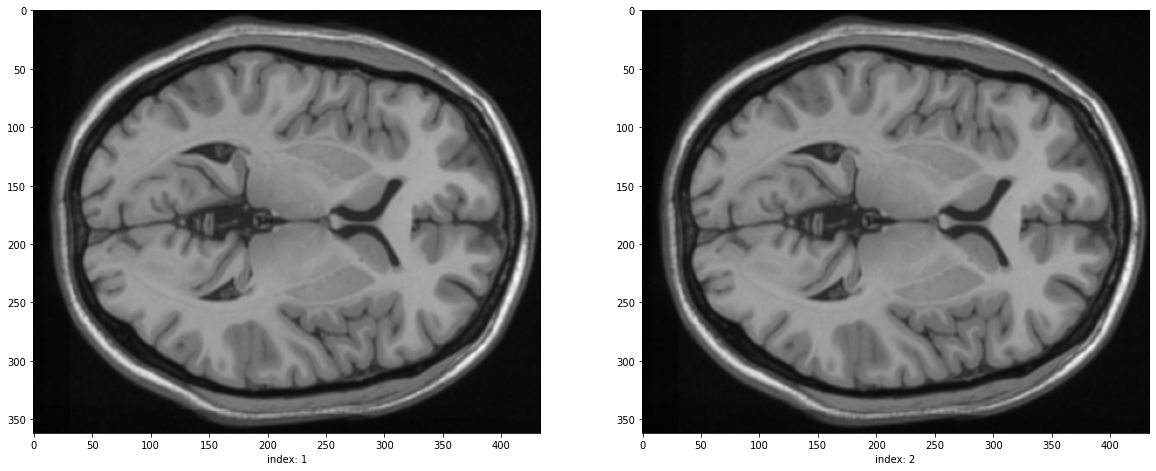

In [8]:
plot_multi([sample, sample_std])

### Storing the images for understanding the data better

In [9]:
### creating a folder to store images
data_folder = 'data'
os.makedirs('data',exist_ok=True)

In [10]:
images = []
labels = []
for i in range(10):
    img = T1[:,:,i]
    
    ### standardising the float values between int of range(0-255)
    img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    images.append(img)
    lab = label[:,:,i]
    labels.append(lab)
#     lab1 = ((lab - lab.min()) * (1/(lab.max() - lab.min()) * 255)).astype('uint8')
    lab1 = imshow_components(lab)
    cv2.imwrite(os.path.join(data_folder,f'{i}_image.png'),img)
    cv2.imwrite(os.path.join(data_folder,f'{i}_gt.png'),lab)
    cv2.imwrite(os.path.join(data_folder,f'{i}_image_gt.png'),lab1)
    
###reference: https://stackoverflow.com/a/49922520/9605907

In [11]:
### listing the created images in the data folder
sorted(os.listdir(data_folder))[0:10]

['.DS_Store',
 '0_gt.png',
 '0_image.png',
 '0_image_gt.png',
 '1_gt.png',
 '1_image.png',
 '1_image_gt.png',
 '2_gt.png',
 '2_image.png',
 '2_image_gt.png']

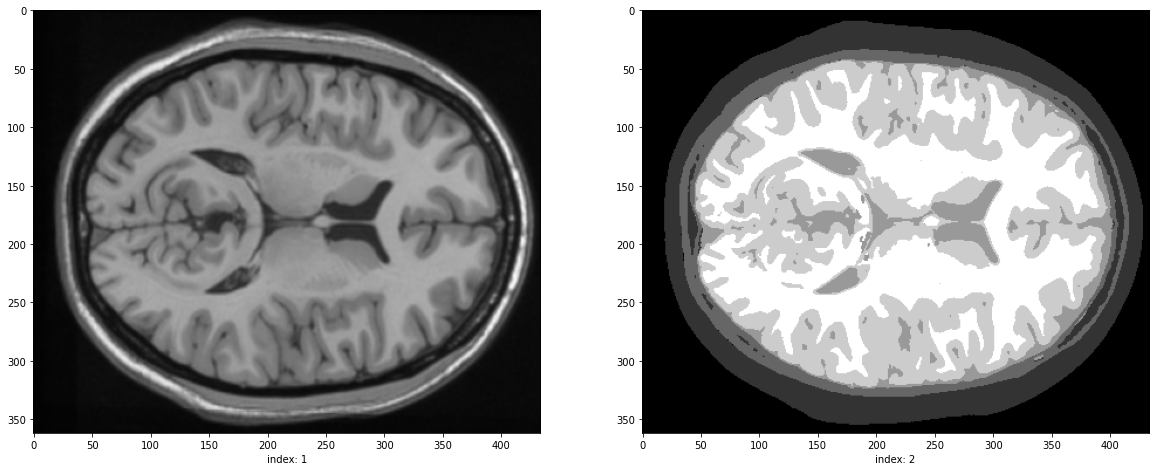

In [12]:
### Visualising a sample input image and it's expected groundtruth
plot_multi([images[9],labels[9]],cmap = 'gray')

### Segementation classes

- For a given MRI image, we need to segment them into 6 categories namely: air, skin, skull, csf, gray matter and white matter

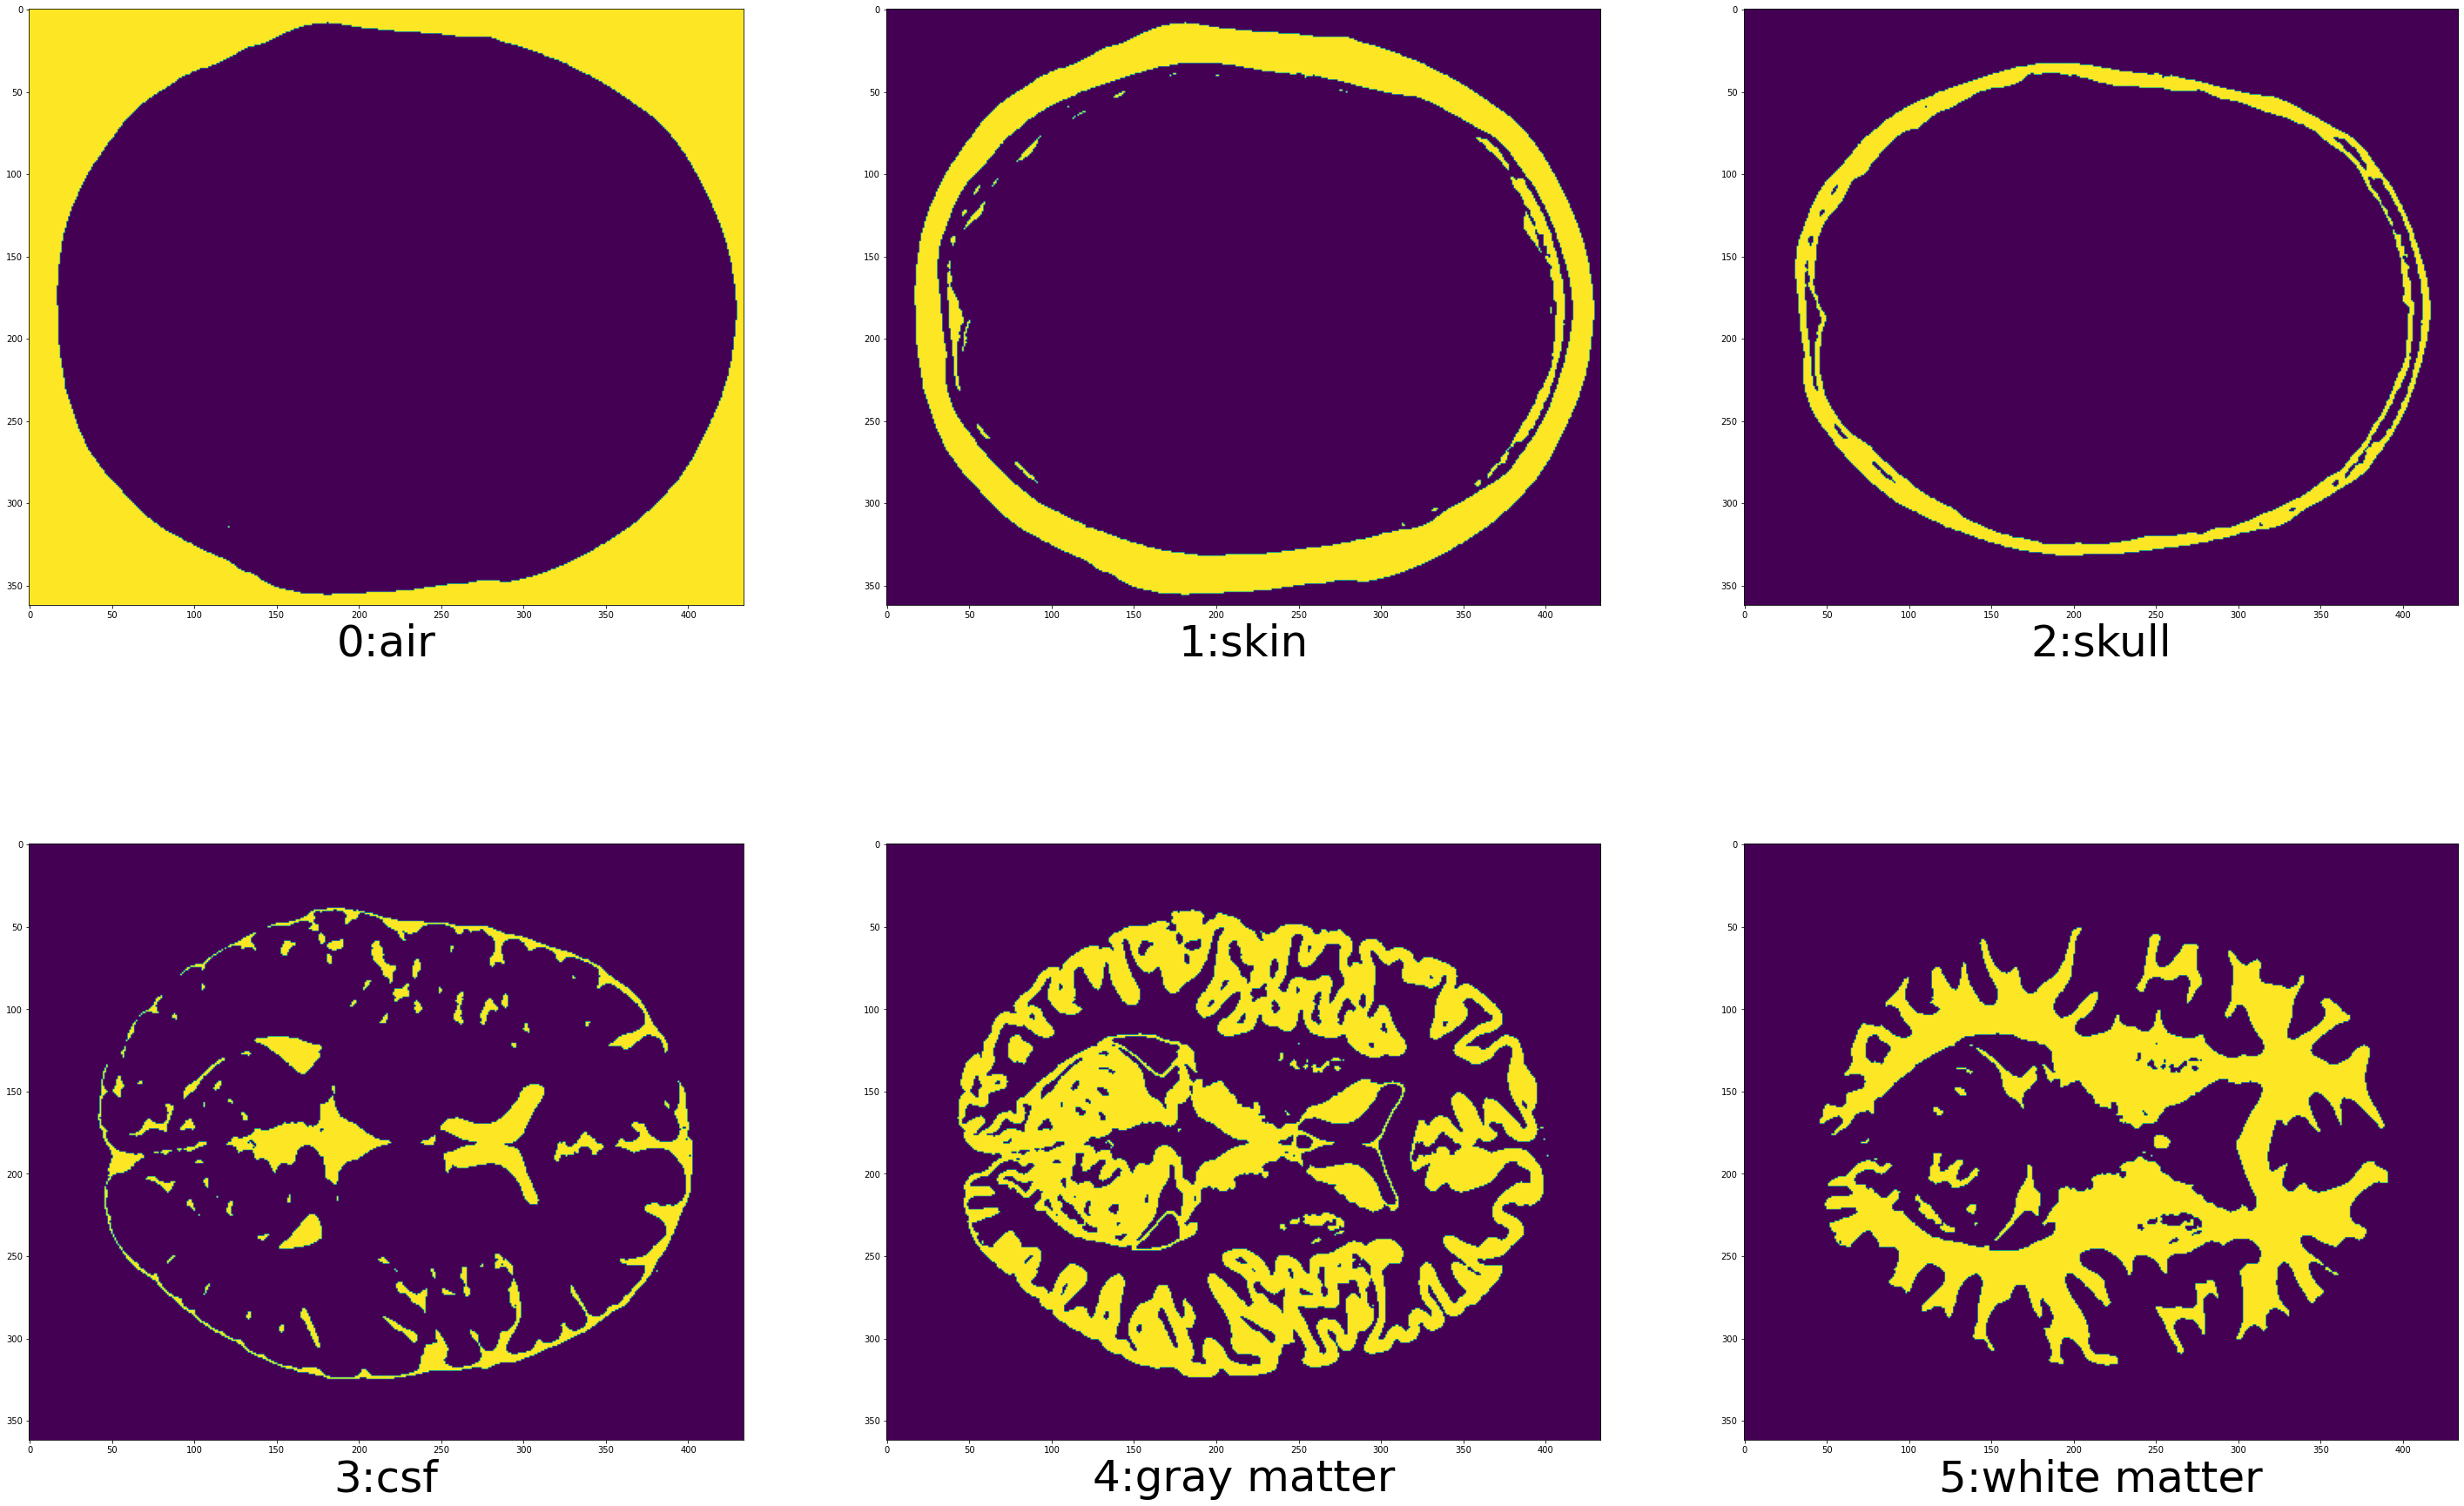

In [14]:
input_image = images[5]
label_image = labels[5]
label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
plt.figure(figsize=(50, 50))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(label_image==i)
    plt.xlabel(f"{i}:{label_index[i]}",fontsize=50)

## Evaluating the performance
- Before we move on to different approaches in obtaining the segmentation, we will first define the evaluation metrics and get an accuracy measure with the groundtruth and verify the logics. 

In [19]:
def pixelwise_IOU_label(input_image, ground_truth, label_class = 1):
    mask1 = input_image == label_class
    mask2 = ground_truth == label_class
    iou_score = IOU_binary(mask1, mask2)
    return iou_score

In [20]:
def IOU_binary(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [21]:
def dice_binary(mask1, mask2):
    mask1_pos = mask1.astype(np.float32)
    mask2_pos = mask2.astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

In [22]:
# def categorical_dice_label(mask1, mask2, label_class = 1):
#     """
#     Dice score of a specified class between two volumes of label masks.
#     (classes are encoded but by label class number not one-hot )
#     Note: stacks of 2D slices are considered volumes.

#     Args:
#         mask1: N label masks, numpy array shaped (H, W, N)
#         mask2: N label masks, numpy array shaped (H, W, N)
#         label_class: the class over which to calculate dice scores

#     Returns:
#         volume_dice
#     """
#     mask1_pos = (mask1 == label_class).astype(np.float32)
#     mask2_pos = (mask2 == label_class).astype(np.float32)
#     dice = dice_binary(mask1_pos,mask2_pos)
#     return dice

In [52]:
def score_image(predict, label):
    label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
    scores = []
    for pix_val, category in label_index.items():
        predict_mask = (predict == pix_val)
        label_mask = (label == pix_val)        
        dice = dice_binary(predict_mask, label_mask)
        scores.append(dice)
    return scores

In [54]:
import pandas as pd

def score_images(predicts, labels):
    df = pd.DataFrame(columns=['air','skin','skull','csf','gray matter','white matter','average'])
    for i, (predict, label) in enumerate(zip(predicts,labels)):
        scores = calculate_dice(predict,label)
        scores.append(sum(scores)/len(scores))
        df.loc[i] = scores
    print("Dice scores:")
    for label in df.columns:
        print(f"{label} : {df[label].mean()}")
    return df
def score_images(predicts, labels):
    df = pd.DataFrame(columns=['air','skin','skull','csf','gray matter','white matter','average'])
    for i, (predict, label) in enumerate(zip(predicts,labels)):
        scores = calculate_dice(predict,label)
        scores.append(sum(scores)/len(scores))
        df.loc[i] = scores
    print("Dice scores:")
    for label in df.columns:
        print(f"{label} : {df[label].mean()}")
    return df
df = score_images(labels,labels)
df

Dice scores:
air : 1.0
skin : 1.0
skull : 1.0
csf : 1.0
gray matter : 1.0
white matter : 1.0
average : 1.0


,air,skin,skull,csf,gray matter,white matter,average
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## MRI Segementation - Approach 1 : Thresholding

- From the data, we can see that the pixels values are different for different segments and we can arrive at a basic segmentaion model by applying thresholding at multiple levels. 

### Plotting Histogram of a sample image 

(0.0, 256.0)

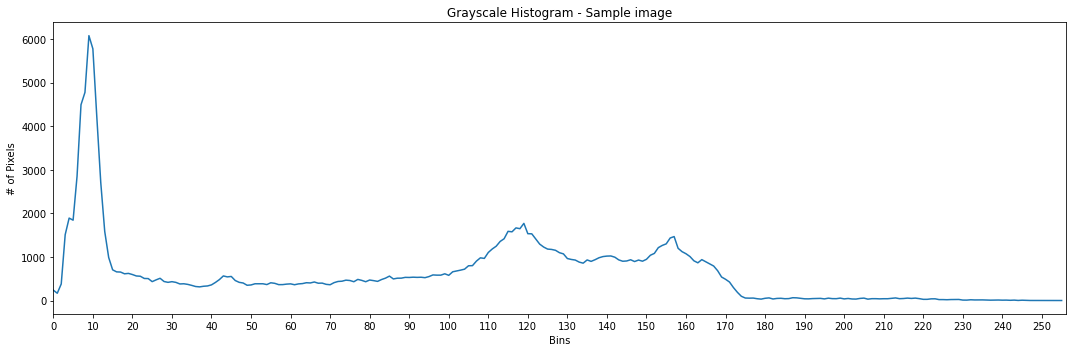

In [135]:
hist = cv2.calcHist([input_image], [0], None, [256], [0, 256])
plt.rcParams["figure.figsize"] = [15,5]
plt.rcParams["figure.autolayout"] = True
plt.figure()
plt.title("Grayscale Histogram - Sample image")
plt.xlabel("Bins")
plt.xticks(list(range(0,255,10)))
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

- From the histogram, we can see that there are some peaks which might be representing a particular class of interest

- To arrive at thresholds which will hold for all 10 images, creating an average image and taking the histogram

In [143]:
avg_image = np.mean(images, axis=0).astype(np.uint8)
avg_image.shape

(362, 434)

(0.0, 256.0)

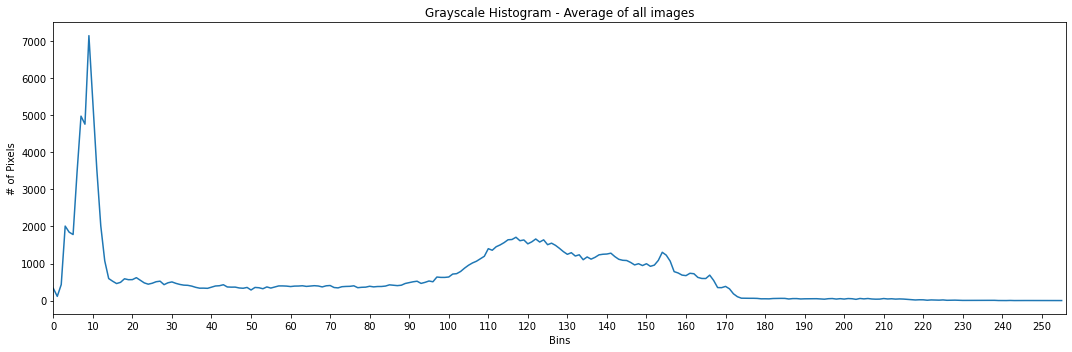

In [144]:
hist = cv2.calcHist([avg_image], [0], None, [256], [0, 256])
plt.rcParams["figure.figsize"] = [15,5]
plt.rcParams["figure.autolayout"] = True
plt.figure()
plt.title("Grayscale Histogram - Average of all images")
plt.xlabel("Bins")
plt.xticks(list(range(0,255,10)))
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

[ 30  69 104 137 179]


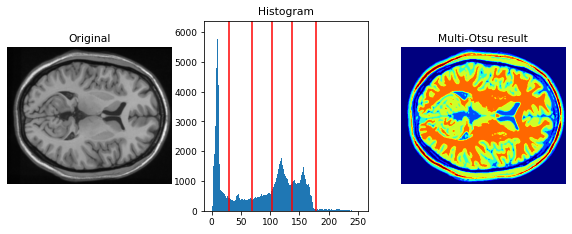

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = input_image.copy()

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image,classes=6)

print(thresholds)
# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()
# source: https://scikit-image.org/docs/stable/install.html

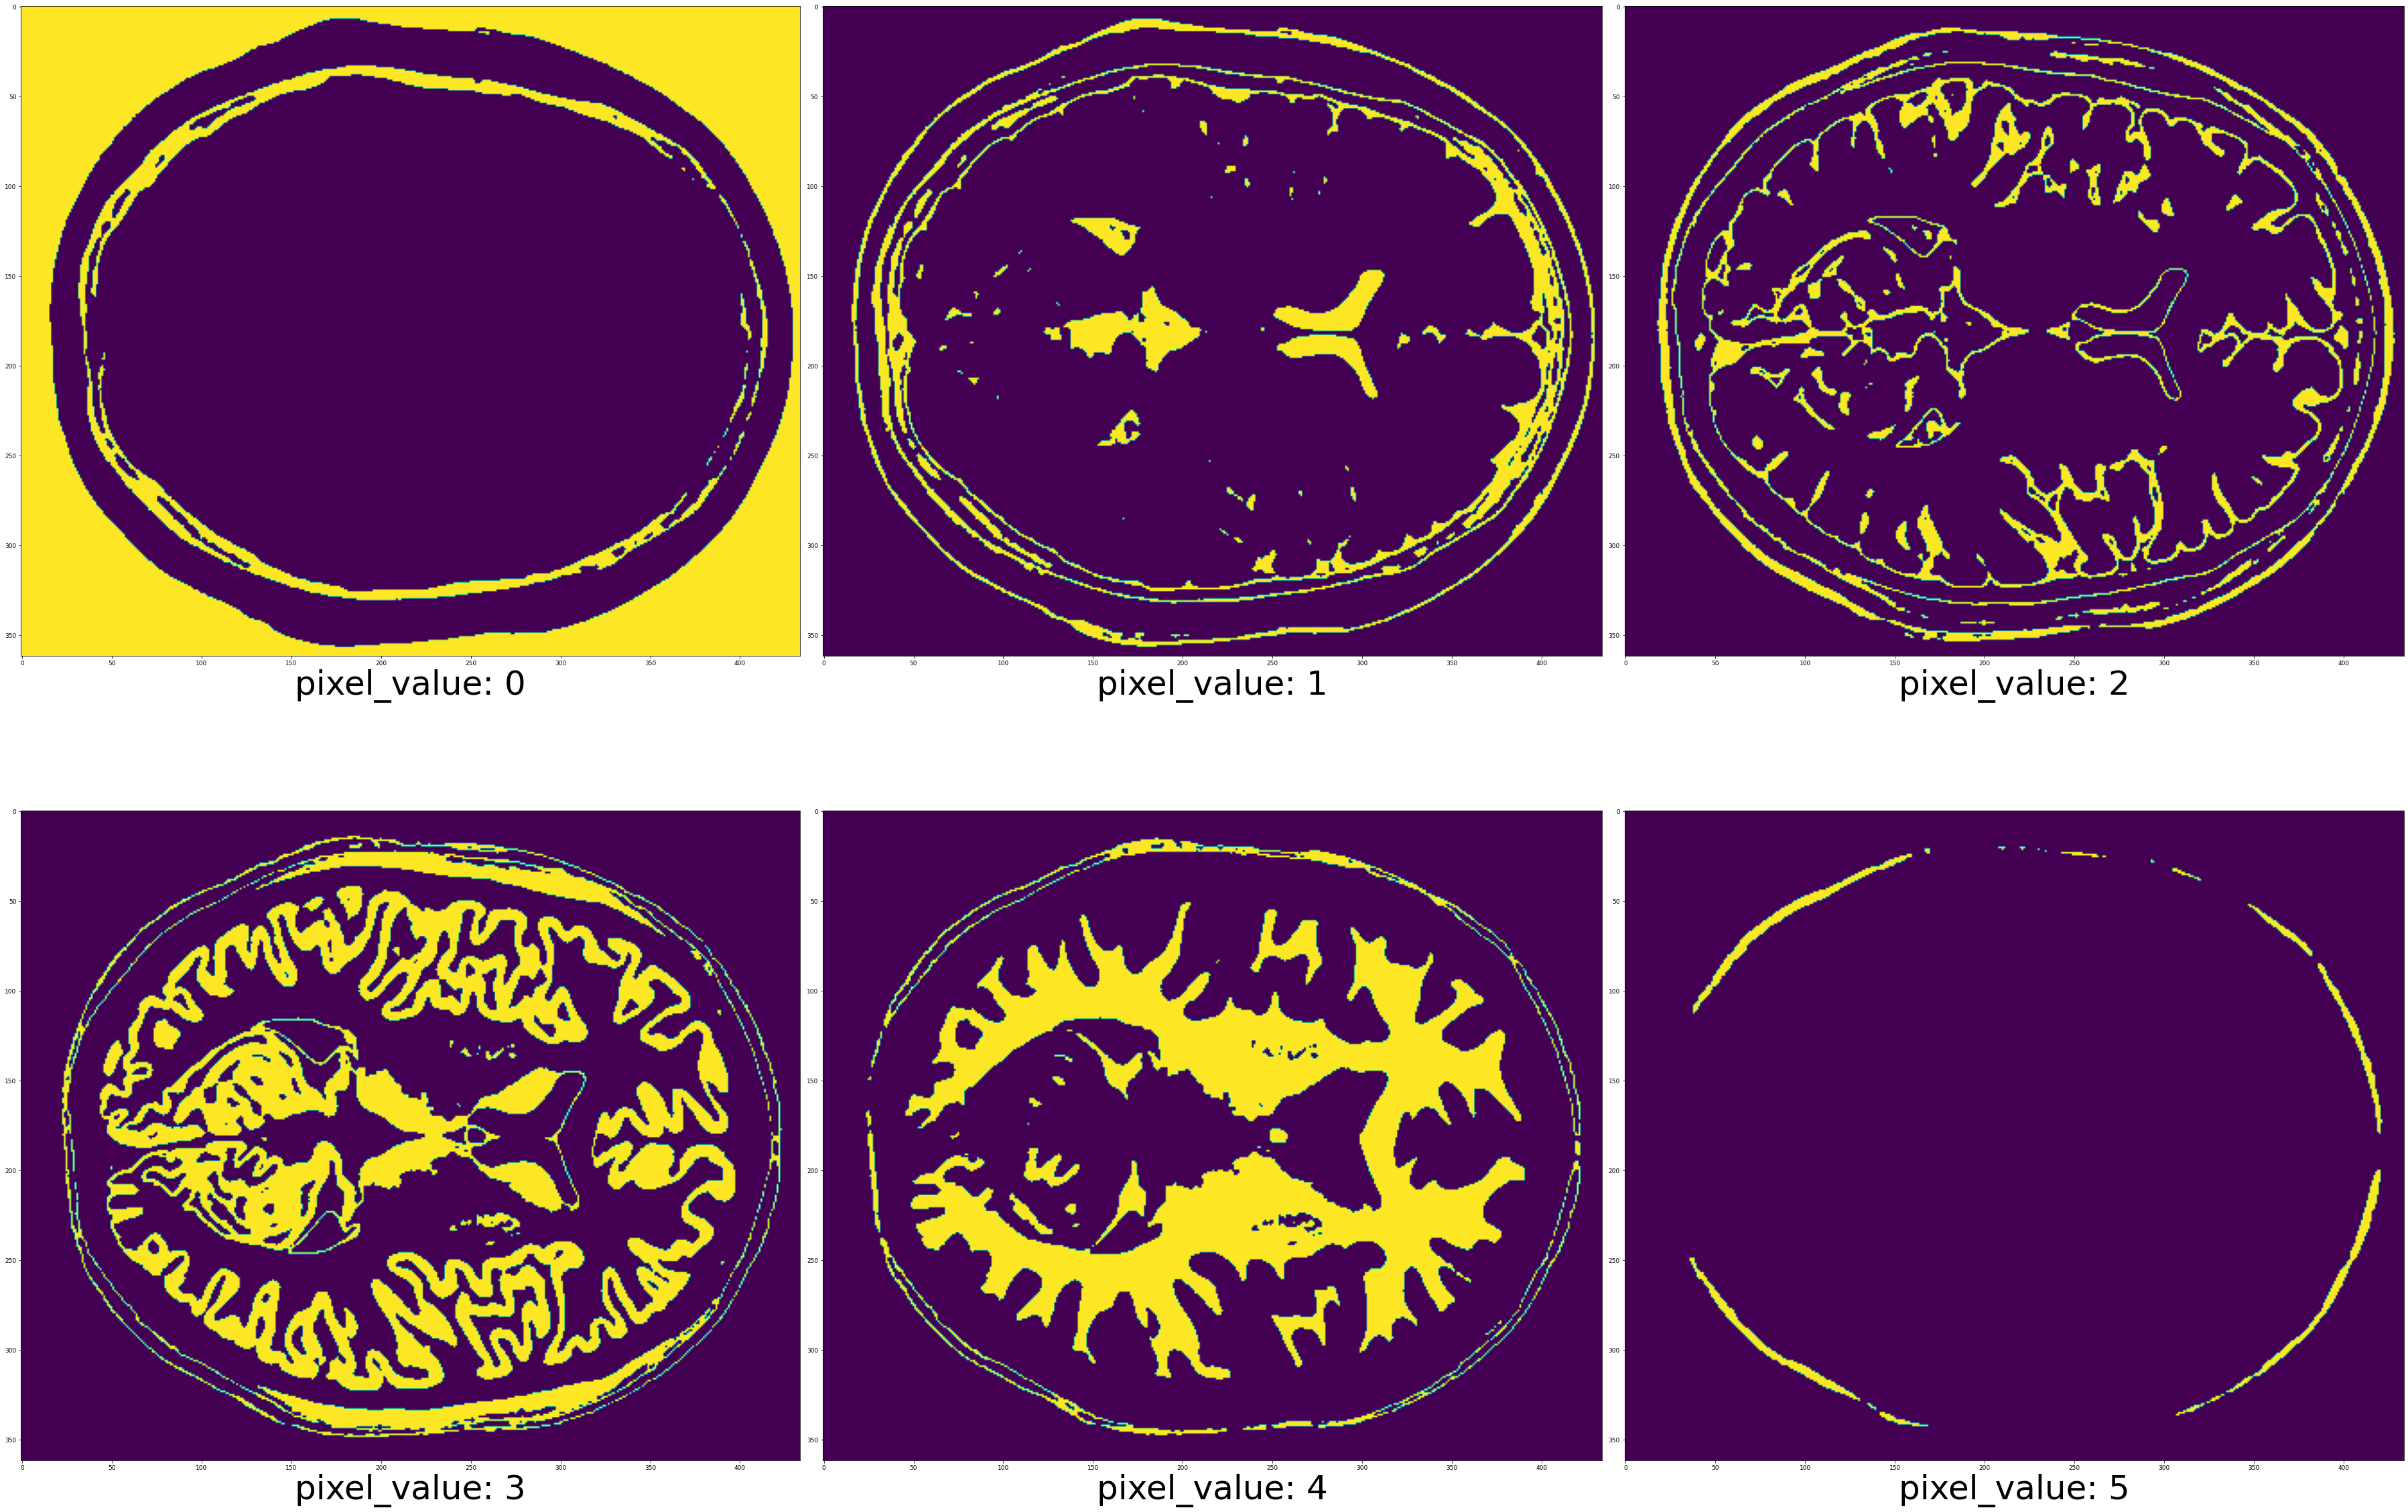

In [148]:
# label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
plt.figure(figsize=(50, 50))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(regions==i)
    plt.xlabel(f"pixel_value: {i}",fontsize=50)

In [75]:
from collections import defaultdict
### evaluating for each class
predict_image = regions
# def match_and_score(predict_image, label_image):
label_list = list(range(0,6))
label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
# label_list =[0,1]
dice_score = []
match_dict = {}
score = {}
# print(match_dict)
dice_scores = []
for l in label_list:
    ground_list = []
    max_score = 0
    for k in label_index.keys():
        iou = IOU_binary(predict_image == k, label_image == l)
        dice = dice_binary(predict_image == k, label_image == l)
        ground_list.append(dice)
        if dice > max_score:
            if !match_dict:
                match_dict[l]["match"] = k
                match_dict[l]["score"] = dice
            elif k not in [match_dict[x]['match'] for x in match_dict.keys()]:
                match_dict[l]['match'] = k
                match_dict[l]['score'] = dice
            elif k in [match_dict[x]['match'] for x in match_dict.keys()]:
                
                max_score = dice
    dice_scores.append(ground_list)
# dice_scores

In [83]:
import pandas as pd
df = pd.DataFrame(dice_scores)
# df.reset_index(inplace = True)
df

,0,1,2,3,4,5
0,0.917493,0.041884,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.246449,0.326913,0.214468,0.099267,0.182976
2,0.218708,0.250090,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.484644,0.299259,0.004836,0.000264,0.000000
4,0.000000,0.000000,0.239898,0.820272,0.009793,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.950729,0.000000


In [85]:
df.max(axis=0).mean()

0.6138377964028477